### 接續上週(20211005)的Cox PH Model

#### Exponential with $\alpha = -0.5$, $\beta = 0.5$

+ $S(t) = exp\{-exp(\alpha + \beta Z)t\}\sim U(0, 1) \equiv U$
+ Event Time: $T = \frac{-log(U)}{e^{\alpha + \beta Z}}$
+ Censoring用exponential來生成。

In [1]:
library(survival)

In [2]:
generate.data = function(N, par){
  # true value
  alpha = par[1]
  beta = par[2]
  # generate one dimension covariate
  z = sample(c(0, 1), N, p = c(0.5, 0.5), replace = T)
  # prepare uniform rv to generate event time
  u = runif(N)
  # find the cdf inverse function
  cdf.inverse = function(unif, alpha, beta){
    return (-log(u) / exp(alpha + beta * z))
  }
  # generate the event time
  e = cdf.inverse(unif, alpha, beta)
  # generate the censoring
  c = rexp(N, 0.25)
  
  # compare event time and censoring and get observations time and delta
  o = c()
  delta = c()
  for (i in 1:N){
    if (e[i] >= c[i]){
      o[i] = c[i]
      delta[i] = 0
    }else{
      o[i] = e[i]
      delta[i] = 1
    }
  }
  dt = data.frame(observation = o, delta = delta, covariate = z)
  return (dt)
}

In [3]:
dt = generate.data(N = 300, par = c(-0.5, 0.5))
print(head(dt, 30))

   observation delta covariate
1   1.20122847     0         0
2   0.63314735     0         0
3   0.04688142     1         1
4   0.38661789     0         1
5   0.29062345     1         1
6   1.64615891     0         1
7   0.93906627     0         1
8   0.85021494     0         1
9   0.51579389     0         1
10  0.48409159     1         1
11  0.09519517     1         0
12  1.32828939     0         0
13  2.04348258     1         1
14  0.03762175     1         0
15  0.38462980     1         0
16  0.20167165     1         0
17  1.72695174     1         1
18  2.54979004     0         0
19  0.62958957     1         0
20  0.19942505     1         0
21  0.49146053     1         1
22  0.06012356     0         1
23  2.40424199     0         1
24  0.04179350     1         1
25  0.71912555     1         0
26  0.15110219     1         0
27  1.15281263     1         1
28  0.87119395     0         0
29  0.98189034     1         1
30  0.29329339     0         0


找出$\beta$估計值。

In [4]:
fit = coxph(Surv(observation, delta) ~ covariate, data = dt, method = "breslow")
beta_hat = summary(fit)$coef[1]
print(beta_hat)

[1] 0.5276868


將資料依據觀察時間由小到大排序。

In [5]:
ord = order(dt$observation)
dt = dt[c(ord), ]
print(head(dt, 30))

     observation delta covariate
148 0.0007584254     1         0
75  0.0007716062     1         1
69  0.0039017135     1         0
39  0.0053283086     0         0
180 0.0111809383     1         1
299 0.0137402739     1         1
42  0.0147732883     0         0
145 0.0165100387     1         0
190 0.0214972248     1         0
37  0.0229616400     1         0
291 0.0231801105     1         1
176 0.0259919973     1         0
119 0.0291544185     0         0
191 0.0323249801     0         1
14  0.0376217549     1         0
136 0.0383098292     0         1
24  0.0417934989     1         1
3   0.0468814215     1         1
67  0.0483345398     1         0
251 0.0508596960     1         1
256 0.0578391273     0         0
47  0.0584297176     1         1
22  0.0601235620     0         1
152 0.0658209117     1         1
49  0.0685711484     0         1
154 0.0689309009     1         1
64  0.0779566054     1         0
234 0.0804388751     1         1
61  0.0858848664     1         1
138 0.0943

In [6]:
d_Lambda_hat = c()
n = c()
d = c()
L = length(dt[, 1])
for (i in 1:L){
  numerator = dt[i, 2]
  denominator = sum(exp(beta_hat * dt[c(i:L), 3]))
  n = c(n, numerator)
  d = c(d, denominator)
  d_Lambda_hat = c(d_Lambda_hat, (numerator/denominator))
}

dt = data.frame(dt, numerator = n, denominator = d, dLambda = d_Lambda_hat)
print(head(dt, 30))

     observation delta covariate numerator denominator     dLambda
148 0.0007584254     1         0         1    404.9460 0.002469465
75  0.0007716062     1         1         1    403.9460 0.002475578
69  0.0039017135     1         0         1    402.2510 0.002486010
39  0.0053283086     0         0         0    401.2510 0.000000000
180 0.0111809383     1         1         1    400.2510 0.002498432
299 0.0137402739     1         1         1    398.5560 0.002509057
42  0.0147732883     0         0         0    396.8610 0.000000000
145 0.0165100387     1         0         1    395.8610 0.002526139
190 0.0214972248     1         0         1    394.8610 0.002532537
37  0.0229616400     1         0         1    393.8610 0.002538967
291 0.0231801105     1         1         1    392.8610 0.002545429
176 0.0259919973     1         0         1    391.1660 0.002556459
119 0.0291544185     0         0         0    390.1660 0.000000000
191 0.0323249801     0         1         0    389.1660 0.00000

計算$\hat{\Lambda}_0(t)$

計算方式：$\hat{\Lambda}_0(t) = \sum\limits_{s\leq t}d\hat{\Lambda}_0(s)$

計算上可以使用`cumsum`來輔助計算。

In [7]:
Lambda = cumsum(d_Lambda_hat)
dt = data.frame(dt, Lambda = Lambda)
print(head(dt, 30))

     observation delta covariate numerator denominator     dLambda      Lambda
148 0.0007584254     1         0         1    404.9460 0.002469465 0.002469465
75  0.0007716062     1         1         1    403.9460 0.002475578 0.004945043
69  0.0039017135     1         0         1    402.2510 0.002486010 0.007431053
39  0.0053283086     0         0         0    401.2510 0.000000000 0.007431053
180 0.0111809383     1         1         1    400.2510 0.002498432 0.009929485
299 0.0137402739     1         1         1    398.5560 0.002509057 0.012438542
42  0.0147732883     0         0         0    396.8610 0.000000000 0.012438542
145 0.0165100387     1         0         1    395.8610 0.002526139 0.014964681
190 0.0214972248     1         0         1    394.8610 0.002532537 0.017497218
37  0.0229616400     1         0         1    393.8610 0.002538967 0.020036184
291 0.0231801105     1         1         1    392.8610 0.002545429 0.022581614
176 0.0259919973     1         0         1    391.16

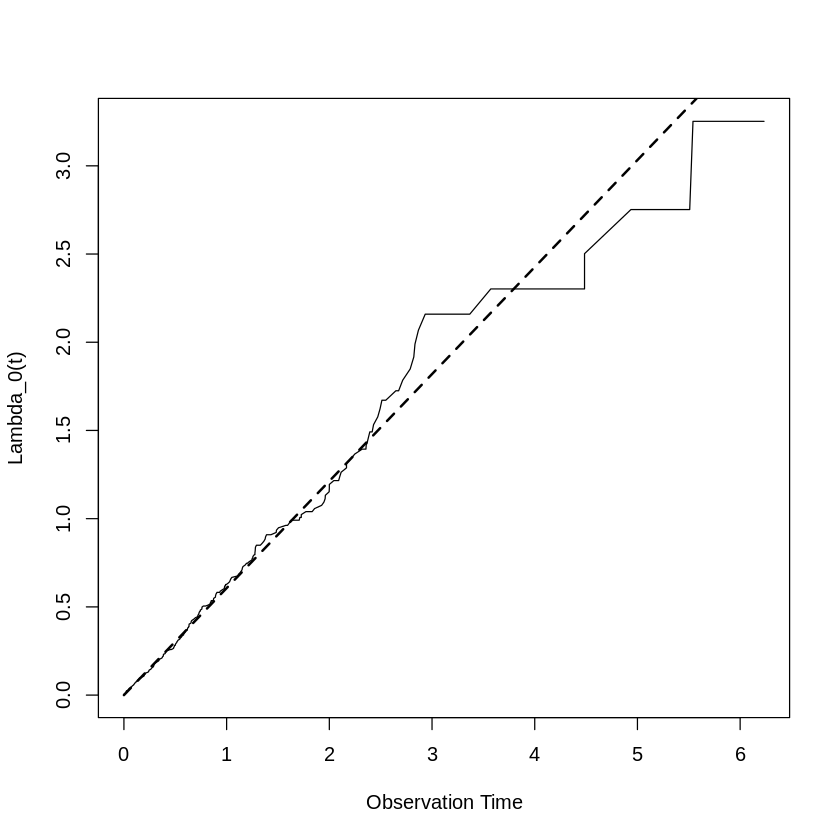

In [8]:
plot(dt[, 1], Lambda, type = "l", xlab = "Observation Time", ylab = "Lambda_0(t)")
x = seq(0, 9, 0.1)
lines(x, x * exp(-0.5), lty = 2, lwd = 2)

+ 在每個觀察時間下的$\hat{\Lambda}_0(t)$都被計算出來並畫成圖。
+ 距離0附近的估計會與理論值（虛線）接近。
+ 基本上離0越遠的地方有可能偏離理論值（虛線）越多，是因為樣本因為failure不斷的變少，所以會有偏離的情況。

---

#### Weibull with $\alpha = -0.5$, $\beta = 0.5$, $\gamma = 2$

+ $S(t) = exp\{-t^{\gamma}exp(\alpha + \beta Z)\} \sim U(0, 1) \equiv U$, where $\gamma > 0$
+ $T = (\frac{-log(1 - U)}{e^{\alpha + \beta Z}})^{\frac{1}{\gamma}}$

In [9]:
generate.data.w = function(N, par){
  # true value
  alpha = par[1]
  beta = par[2]
  gamma = par[3]
  # generate one dimension covariate
  z = sample(c(0, 1), N, p = c(0.5, 0.5), replace = T)
  # prepare uniform rv to generate event time
  u = runif(N)
  # find the cdf inverse function
  cdf.inverse = function(unif, alpha, beta, gamma){
    return ((-log(1 - u) / exp(alpha + beta * z))^(1/gamma))
  }
  # generate the event time
  e = cdf.inverse(unif, alpha, beta, gamma)
  # generate the censoring
  c = rexp(N, 0.25)
  
  # compare event time and censoring and get observations time and delta
  o = c()
  delta = c()
  for (i in 1:N){
    if (e[i] >= c[i]){
      o[i] = c[i]
      delta[i] = 0
    }else{
      o[i] = e[i]
      delta[i] = 1
    }
  }
  dt = data.frame(observation = o, delta = delta, covariate = z)
  return (dt)
}

In [10]:
dat = generate.data.w(N = 300, par = c(-0.5, 0.5, 2))
print(head(dat, 30))

   observation delta covariate
1   1.88263443     0         0
2   1.02880353     1         1
3   0.45906660     0         0
4   0.91531590     1         0
5   1.36882208     1         0
6   1.18290376     1         1
7   0.75253834     1         1
8   0.93292387     1         1
9   0.31052469     0         1
10  1.42932686     1         1
11  0.41339408     1         1
12  0.41320665     0         0
13  1.45269223     1         0
14  0.59657412     1         0
15  2.34265786     1         0
16  0.24003672     1         1
17  0.97420908     1         0
18  1.05751405     0         0
19  1.10687419     1         1
20  0.45554114     1         0
21  1.95345780     1         0
22  0.06912666     1         1
23  2.14418720     1         0
24  0.61465247     0         0
25  1.26934296     1         0
26  0.91030928     1         1
27  1.09592732     1         0
28  0.59396240     1         1
29  0.51106316     1         0
30  1.63991775     1         0


Use the Cox PH Model to estimate the $\hat{\beta}$

In [11]:
fit = coxph(Surv(observation, delta) ~ covariate, data = dat, method = "breslow")
beta_hat = summary(fit)$coef[1]
print(beta_hat)

[1] 0.5909135


In [12]:
ord = order(dat$observation)
dat = dat[c(ord), ]
print(head(dat, 30))

    observation delta covariate
173 0.001613250     0         1
150 0.009141777     0         0
84  0.013650679     0         1
181 0.021750439     0         0
43  0.032968160     1         1
157 0.043032043     0         1
145 0.059799075     1         0
22  0.069126659     1         1
300 0.093763938     0         0
146 0.095020598     0         0
42  0.105055780     1         1
226 0.118743746     1         1
236 0.144123985     1         0
117 0.146680912     0         1
197 0.149596630     1         1
52  0.159756415     1         1
259 0.163115316     1         0
298 0.173285985     1         0
287 0.174928650     1         1
143 0.188321338     1         0
73  0.199491976     0         1
272 0.204797080     1         1
241 0.219875260     1         1
109 0.223153804     1         0
103 0.227098902     0         1
257 0.228028570     1         1
153 0.233098056     1         1
261 0.238199610     1         0
16  0.240036721     1         1
190 0.245170238     1         1


In [13]:
d_Lambda_hat = c()
n = c()
d = c()
L = length(dat[, 1])
for (i in 1:L){
  numerator = dat[i, 2]
  denominator = sum(exp(beta_hat * dat[c(i:L), 3]))
  n = c(n, numerator)
  d = c(d, denominator)
  d_Lambda_hat = c(d_Lambda_hat, (numerator/denominator))
}

dat = data.frame(dat, numerator = n, denominator = d, dLambda = d_Lambda_hat)
print(head(dat, 30))

    observation delta covariate numerator denominator     dLambda
173 0.001613250     0         1         0    406.3441 0.000000000
150 0.009141777     0         0         0    404.5385 0.000000000
84  0.013650679     0         1         0    403.5385 0.000000000
181 0.021750439     0         0         0    401.7328 0.000000000
43  0.032968160     1         1         1    400.7328 0.002495428
157 0.043032043     0         1         0    398.9272 0.000000000
145 0.059799075     1         0         1    397.1216 0.002518121
22  0.069126659     1         1         1    396.1216 0.002524478
300 0.093763938     0         0         0    394.3159 0.000000000
146 0.095020598     0         0         0    393.3159 0.000000000
42  0.105055780     1         1         1    392.3159 0.002548966
226 0.118743746     1         1         1    390.5103 0.002560752
236 0.144123985     1         0         1    388.7046 0.002572647
117 0.146680912     0         1         0    387.7046 0.000000000
197 0.1495

In [14]:
Lambda = cumsum(d_Lambda_hat)
dat = data.frame(dat, Lambda = Lambda)
print(head(dat, 30))

    observation delta covariate numerator denominator     dLambda      Lambda
173 0.001613250     0         1         0    406.3441 0.000000000 0.000000000
150 0.009141777     0         0         0    404.5385 0.000000000 0.000000000
84  0.013650679     0         1         0    403.5385 0.000000000 0.000000000
181 0.021750439     0         0         0    401.7328 0.000000000 0.000000000
43  0.032968160     1         1         1    400.7328 0.002495428 0.002495428
157 0.043032043     0         1         0    398.9272 0.000000000 0.002495428
145 0.059799075     1         0         1    397.1216 0.002518121 0.005013549
22  0.069126659     1         1         1    396.1216 0.002524478 0.007538027
300 0.093763938     0         0         0    394.3159 0.000000000 0.007538027
146 0.095020598     0         0         0    393.3159 0.000000000 0.007538027
42  0.105055780     1         1         1    392.3159 0.002548966 0.010086993
226 0.118743746     1         1         1    390.5103 0.00256075

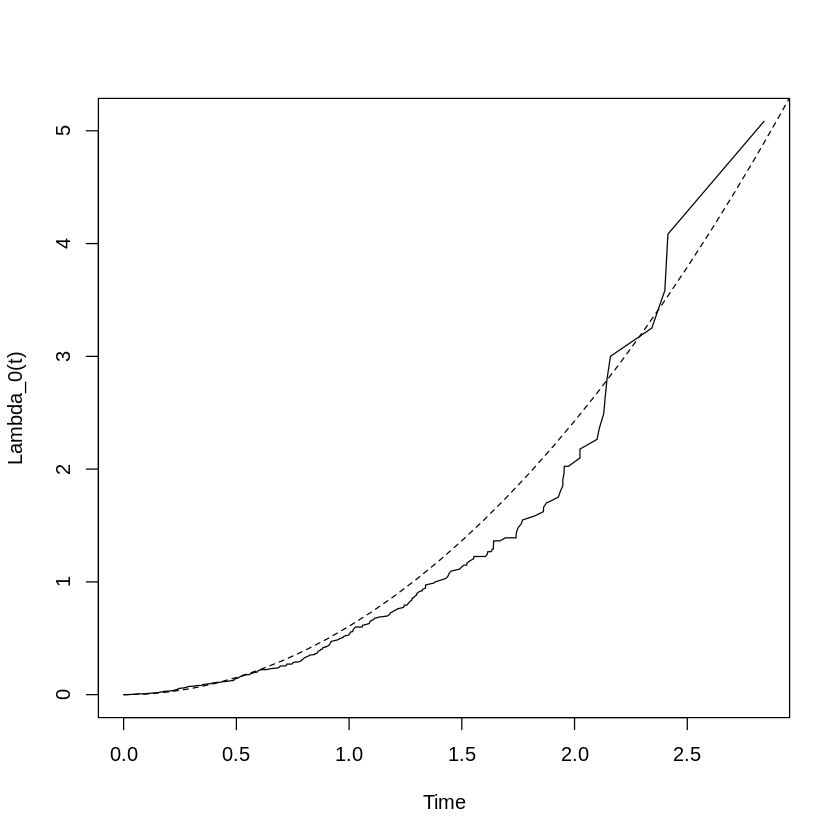

In [15]:
plot(dat[, 1], Lambda, type = "l", xlab = "Time", ylab = "Lambda_0(t)")
x = seq(0, 10, 0.1)
lines(x, x^2 * exp(-0.5), lty = 2)

+ 跟指數的case一樣，離0越近越接近理論值，離0越遠的偏離原因也與前面相似，不贅述。

---

現在改成非指數非韋伯的case。

```
這邊有點問題
```

給定a = 0.1, b = 0.5, $\lambda(t) = a + bt$, $\beta = 0.5$, $Z\sim Ber(p = 0.5)$

```
這邊有點問題
```

$S(t) = exp\{-(\frac{1}{2}t + \frac{1}{4}t^2)exp(0.5Z)\}\sim U(0, 1)\equiv U$

$T = \sqrt{1 - \frac{4log(u)}{e^{0.5Z}}} - 1$

In [16]:
n = 300
u = runif(n)
z = rbinom(n, 1, 0.5)

e = sqrt(1 - (4 * log(u) / exp(0.5 * z))) - 1
c = rexp(n, 0.25)

o = c()
delta = c()
for (i in 1:n){
  if (e[i] > c[i]){
    o[i] = c[i]
    delta[i] = 0
  }else{
    o[i] = e[i]
    delta[i] = 1
  }
}

dt = data.frame(Observation = o, Delta = delta, Z = z)
print(head(dt, 30))

   Observation Delta Z
1   0.91989904     1 0
2   3.00055275     0 1
3   0.30981819     1 0
4   0.33099999     1 1
5   0.02474090     1 1
6   0.95699329     1 1
7   1.68345402     1 1
8   0.34213810     1 1
9   0.41112307     1 0
10  2.02448406     1 0
11  0.37504403     1 1
12  0.99301808     1 0
13  1.50865111     1 1
14  0.15679441     1 0
15  2.11354259     1 1
16  1.28138311     1 0
17  0.16130590     1 1
18  0.55847678     1 1
19  0.56743178     1 1
20  2.00819458     1 0
21  0.47514183     1 1
22  1.00775423     1 0
23  0.02524742     0 1
24  0.53471524     1 1
25  0.17053386     1 1
26  1.52994240     1 0
27  1.51634902     1 1
28  0.47912959     1 1
29  0.65261347     0 1
30  0.64906135     1 0


用Cox PH Model估出$\beta$的估計值$\hat{\beta}$

In [17]:
fit = coxph(Surv(Observation, Delta) ~ Z, data = dt, method = "breslow")
beta_hat = summary(fit)$coef[1]
print(beta_hat)

[1] 0.2557647


將資料按照觀察時間由小到大排序。

In [18]:
ord = order(dt$Observation)
dt = dt[c(ord), ]
print(head(dt, 30))

    Observation Delta Z
176 0.008527628     1 1
151 0.009551248     0 1
92  0.014620626     1 1
108 0.023338966     1 0
5   0.024740902     1 1
23  0.025247418     0 1
177 0.025501043     1 0
69  0.027392746     0 1
270 0.027609259     1 0
235 0.028579373     1 1
261 0.031139574     1 1
241 0.035382051     1 0
202 0.036006668     0 0
211 0.044329859     1 1
43  0.046651777     1 1
113 0.049869271     0 1
80  0.052378311     1 1
214 0.064399984     0 0
73  0.065163281     1 1
215 0.072797704     1 0
54  0.077443567     1 1
286 0.078314036     1 0
147 0.078716194     0 1
123 0.089075446     1 1
49  0.090429507     1 1
260 0.092809128     1 1
259 0.105885959     1 0
174 0.114506442     1 0
66  0.115079568     1 0
102 0.115124919     1 1


In [19]:
d_Lambda_hat = c()
n = c()
d = c()
L = length(dt[, 1])
for (i in 1:L){
  numerator = dt[i, 2]
  denominator = sum(exp(beta_hat * dt[c(i:L), 3]))
  n = c(n, numerator)
  d = c(d, denominator)
  d_Lambda_hat = c(d_Lambda_hat, (numerator/denominator))
}

print(d_Lambda_hat)

  [1] 0.002884905 0.000000000 0.002906563 0.002917515 0.002926052 0.000000000
  [7] 0.002948334 0.000000000 0.002968389 0.002977226 0.002988718 0.003000298
 [13] 0.000000000 0.003018410 0.003030222 0.000000000 0.003054126 0.000000000
 [19] 0.003075651 0.003087916 0.003097481 0.003109921 0.000000000 0.003132243
 [25] 0.003144964 0.003157790 0.003170720 0.003180806 0.003190956 0.003201171
 [31] 0.003214460 0.003227859 0.000000000 0.003248833 0.003262522 0.003273200
 [37] 0.003283949 0.003297936 0.000000000 0.000000000 0.003337371 0.000000000
 [43] 0.003359797 0.000000000 0.003382526 0.003394006 0.003408948 0.003420609
 [49] 0.003435787 0.000000000 0.000000000 0.003475086 0.003490752 0.003506560
 [55] 0.003522512 0.003538609 0.003554855 0.003567537 0.003584050 0.003600716
 [61] 0.003617538 0.003634518 0.003647776 0.003661131 0.003674584 0.003688136
 [67] 0.003701789 0.000000000 0.003733458 0.003751546 0.003769811 0.003788254
 [73] 0.003806878 0.003825687 0.000000000 0.003863867 0.00000000

In [20]:
dt = data.frame(dt, numerator = n, denominator = d, dLambda = d_Lambda_hat)
print(head(dt, 30))

    Observation Delta Z numerator denominator     dLambda
176 0.008527628     1 1         1    346.6318 0.002884905
151 0.009551248     0 1         0    345.3404 0.000000000
92  0.014620626     1 1         1    344.0489 0.002906563
108 0.023338966     1 0         1    342.7575 0.002917515
5   0.024740902     1 1         1    341.7575 0.002926052
23  0.025247418     0 1         0    340.4660 0.000000000
177 0.025501043     1 0         1    339.1746 0.002948334
69  0.027392746     0 1         0    338.1746 0.000000000
270 0.027609259     1 0         1    336.8831 0.002968389
235 0.028579373     1 1         1    335.8831 0.002977226
261 0.031139574     1 1         1    334.5917 0.002988718
241 0.035382051     1 0         1    333.3002 0.003000298
202 0.036006668     0 0         0    332.3002 0.000000000
211 0.044329859     1 1         1    331.3002 0.003018410
43  0.046651777     1 1         1    330.0088 0.003030222
113 0.049869271     0 1         0    328.7173 0.000000000
80  0.05237831

In [21]:
Lambda = cumsum(d_Lambda_hat)
print(Lambda)

  [1] 0.002884905 0.002884905 0.005791469 0.008708984 0.011635035 0.011635035
  [7] 0.014583370 0.014583370 0.017551758 0.020528985 0.023517702 0.026518000
 [13] 0.026518000 0.029536410 0.032566633 0.032566633 0.035620759 0.035620759
 [19] 0.038696410 0.041784327 0.044881808 0.047991729 0.047991729 0.051123972
 [25] 0.054268936 0.057426726 0.060597446 0.063778252 0.066969208 0.070170379
 [31] 0.073384838 0.076612698 0.076612698 0.079861531 0.083124052 0.086397253
 [37] 0.089681202 0.092979138 0.092979138 0.092979138 0.096316509 0.096316509
 [43] 0.099676306 0.099676306 0.103058832 0.106452839 0.109861787 0.113282396
 [49] 0.116718183 0.116718183 0.116718183 0.120193269 0.123684021 0.127190581
 [55] 0.130713092 0.134251701 0.137806556 0.141374093 0.144958143 0.148558858
 [61] 0.152176396 0.155810914 0.159458690 0.163119821 0.166794405 0.170482541
 [67] 0.174184330 0.174184330 0.177917788 0.181669334 0.185439145 0.189227399
 [73] 0.193034278 0.196859965 0.196859965 0.200723832 0.20072383

In [22]:
dt = data.frame(dt, Lambda = Lambda)
print(head(dt, 30))

    Observation Delta Z numerator denominator     dLambda      Lambda
176 0.008527628     1 1         1    346.6318 0.002884905 0.002884905
151 0.009551248     0 1         0    345.3404 0.000000000 0.002884905
92  0.014620626     1 1         1    344.0489 0.002906563 0.005791469
108 0.023338966     1 0         1    342.7575 0.002917515 0.008708984
5   0.024740902     1 1         1    341.7575 0.002926052 0.011635035
23  0.025247418     0 1         0    340.4660 0.000000000 0.011635035
177 0.025501043     1 0         1    339.1746 0.002948334 0.014583370
69  0.027392746     0 1         0    338.1746 0.000000000 0.014583370
270 0.027609259     1 0         1    336.8831 0.002968389 0.017551758
235 0.028579373     1 1         1    335.8831 0.002977226 0.020528985
261 0.031139574     1 1         1    334.5917 0.002988718 0.023517702
241 0.035382051     1 0         1    333.3002 0.003000298 0.026518000
202 0.036006668     0 0         0    332.3002 0.000000000 0.026518000
211 0.044329859     

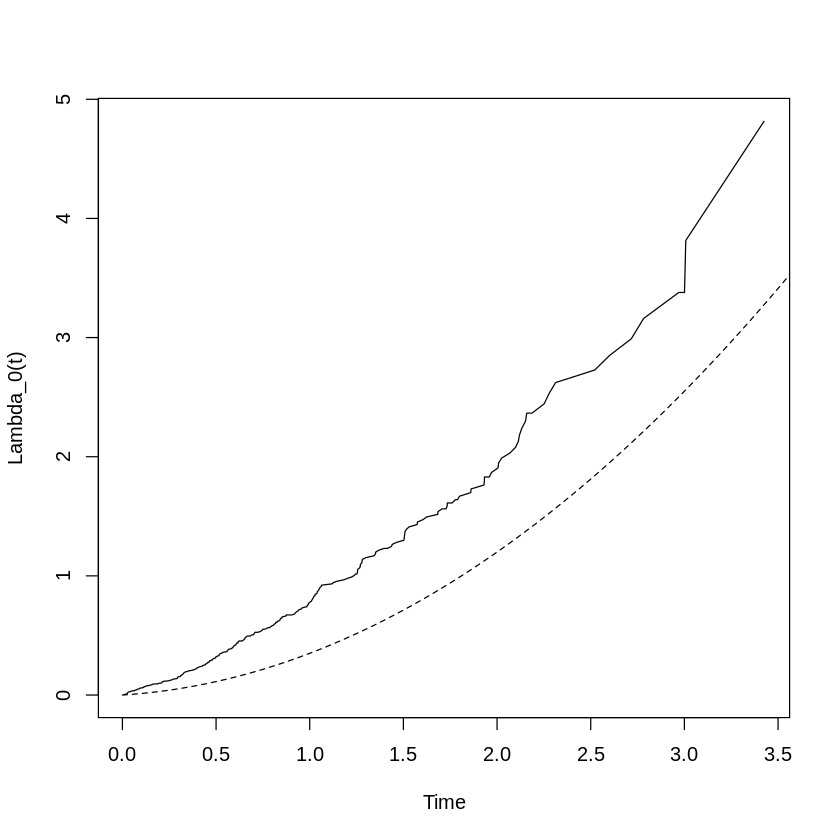

In [23]:
plot(dt[, 1], Lambda, type = "l", xlab = "Time", ylab = "Lambda_0(t)")
x = seq(0, 5, 0.05)
lines(x, 0.1 * x + 0.25 * x^2, lty = 2)

在這邊表現就沒有指數或是韋伯分配的表現那麼好。

---